In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
'''matplotlib.use("pgf")
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'sans-serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})'''

'matplotlib.use("pgf")\nmatplotlib.rcParams.update({\n    \'pgf.texsystem\': \'pdflatex\',\n    \'font.family\': \'sans-serif\',\n    \'text.usetex\': True,\n    \'pgf.rcfonts\': False,\n})'

In [3]:
int32e = np.dtype(np.int32).newbyteorder('>')
uint8e = np.dtype(np.uint8).newbyteorder('>')

In [4]:
def load_images(filename):
    with gzip.open(filename, 'r') as fin:
        buf = fin.read(16)
        _, cnt, rows, cols = np.frombuffer(buf, dtype = int32e)
        buf = fin.read(cnt * rows * cols)
        arr = np.frombuffer(buf, dtype = uint8e).astype('float')
        arr = arr.reshape(cnt, rows, cols) / 255
    return arr
def load_labels(filename):
    with gzip.open(filename, 'r') as fin:
        buf = fin.read(8)
        _, cnt = np.frombuffer(buf, dtype = int32e)
        buf = fin.read(cnt)
        arr = np.frombuffer(buf, dtype = uint8e).astype(np.uint8)
    return arr

In [5]:
def show_image(img):
    img = np.asarray(img).squeeze()
    plt.imshow(img)
    plt.show()

In [6]:
def sample(a):
    return (a > np.random.rand(*a.shape)).astype('float')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
class SGD:
    def __init__(self, learning_rate):
        self.alpha = learning_rate
    def get_update(self, name, gradient):
        return -self.alpha * gradient

class SGDMomentum:
    def __init__(self, learning_rate, momentum):
        self.alpha = learning_rate
        self.momentum = momentum
        self.memory = {}
    def get_update(self, name, gradient):
        if name not in self.memory:
            self.memory[name] = self.alpha * gradient
        else:
            self.memory[name] *= self.momentum
            self.memory[name] += self.alpha * gradient
        return -self.memory[name]

In [87]:
class RBMClassifier:
    
    def __init__(self, visible_num, classes_num, hidden_num):
        self.visible_num = visible_num
        self.classes_num = classes_num
        self.hidden_num = hidden_num
        normal = lambda s: np.random.default_rng().normal(0, 0.05, s)
        self.W = normal((hidden_num, visible_num))
        self.b = normal((visible_num, 1))
        self.c = normal((hidden_num, 1))
        self.d = normal((classes_num, 1))
        self.U = normal((hidden_num, classes_num))
        self.log = {
            'loss' : []
        }
    
    def train(self, epochs, data, labels, minibatch_size, optimizer):
        M = data.shape[0]
        for i in range(epochs):
            permutation = np.random.permutation(M)
            loss = 0;
            for b in range(0, M, minibatch_size):
                minibatch_data = data[permutation[b : b + minibatch_size]]
                minibatch_labels = labels[permutation[b : b + minibatch_size]]
                x0 = sample(minibatch_data).T
                y0 = np.identity(self.classes_num, dtype = 'float')[minibatch_labels].T

                h0P = sigmoid(self.c + self.W @ x0 + self.U @ y0)
                wakeW = h0P @ x0.T
                wakeU = h0P @ y0.T

                h0 = sample(h0P)
                x1 = sample(sigmoid(self.b + self.W.T @ h0))
                y1 = sample(sigmoid(self.d + self.U.T @ h0))
                h1P = sigmoid(self.c + self.W @ x1 + self.U @ y1)
                dreamW = h1P @ x1.T
                dreamU = h1P @ y1.T
                
                self.W -= optimizer.get_update('W', (wakeW - dreamW) / minibatch_size)
                self.U -= optimizer.get_update('U', (wakeU - dreamU) / minibatch_size)
                s = lambda v: np.sum(v, axis = 1, keepdims = True)
                self.b -= optimizer.get_update('b', (s(x0) - s(x1)) / minibatch_size)
                self.c -= optimizer.get_update('c', (s(h0P) - s(h1P)) / minibatch_size)
                self.d -= optimizer.get_update('d', (s(y0) - s(y1)) / minibatch_size)
                
                loss += np.sum((x0 - x1) ** 2) + np.sum((y0 - y1) ** 2)
            self.log['loss'].append(loss / M)
            pickle.dump(self, open(f'checkpoints/checkpoint-{len(self.log["loss"]) - 1:04}', 'wb'))
            print('.', end = '')
        print()
    
    def predict(self, data):
        if len(data.shape) == 1:
            data = data[None, :]
        ans = np.array([], dtype = 'int')
        for i in range(0, data.shape[0], 1000):
            x = data[i : i + 1000].T
            t = (self.c + self.U)[:, :, None] + (self.W @ x)[:, None, :]
            P = self.d + np.sum(np.log1p(np.exp(t)), axis = 0)
            ans = np.append(ans, np.argmax(P, axis = 0))
        return ans
    
    def generate(self, digit, init, iterations = 10):
        x = sample(init).T
        x.shape = (x.size, 1)
        y = np.zeros((self.classes_num, 1), dtype = 'float')
        y[digit, 0] = 1
        for it in range(iterations):
            h = sample(sigmoid(self.c + self.W @ x + self.U @ y))
            xP = sigmoid(self.b + self.W.T @ h)
            x = sample(xP)
        return xP

In [15]:
train_data = load_images('train-images-idx3-ubyte.gz')
train_data = train_data.reshape(train_data.shape[0], -1)
train_labels = load_labels('train-labels-idx1-ubyte.gz')

In [10]:
rbm = RBMClassifier(train_data.shape[1], 10, 100)

In [17]:
rbm.train(200, train_data, train_labels, 60, SGDMomentum(0.01, 0.9))

........................................................................................................................................................................................................


In [11]:
print(rbm.log['loss'])

[]


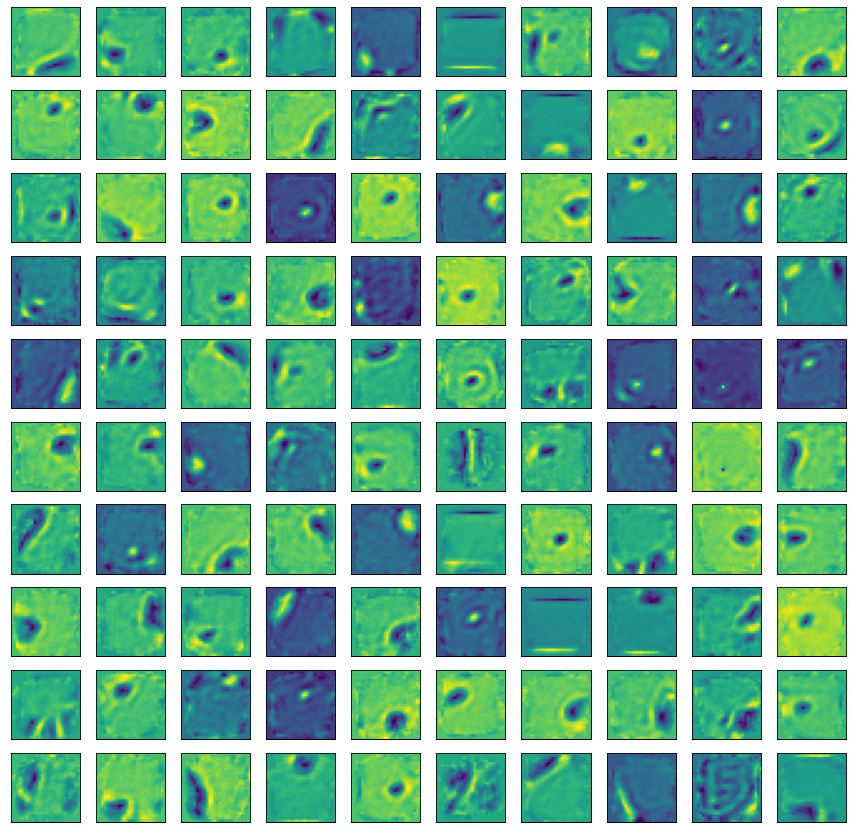

In [167]:
fig, axes = plt.subplots(10, 10)
fig.set_size_inches(15, 15)
for i in range(100):
    a = axes[i // 10][i % 10]
    a.set_xticks([])
    a.set_yticks([])
    a.patch.set_edgecolor('black')
    a.patch.set_linewidth(1)
    a.imshow(rbm.W[i].reshape(28, 28).squeeze())

In [17]:
test_data = load_images('t10k-images-idx3-ubyte.gz')
test_data = test_data.reshape(test_data.shape[0], -1)
test_labels = load_labels('t10k-labels-idx1-ubyte.gz')

In [168]:
np.sum(rbm.predict(test_data) == test_labels) / test_labels.size * 100

90.4

In [165]:
rbm = pickle.load(open('checkpoints/checkpoint-0199', 'rb'))
rbm.train(0, train_data, train_labels, 60, SGDMomentum(0.05,0.9))


Training linear classifier...


In [76]:
print('hidden-units', 'test-accuracy', 'train-accuracy', sep = '\t')
for i in range(100, 1001, 100):
    rbm = pickle.load(open(f'other-checkpoints/{i:04}-checkpoint-0199', 'rb'))
    print(i,
        np.sum(rbm.predict(test_data) == test_labels) / test_labels.size * 100,
        np.sum(rbm.predict(train_data) == train_labels) / train_labels.size * 100, sep = '\t')

hidden-units	test-accuracy	train-accuracy
100	92.86	92.74833333333333


KeyboardInterrupt: 

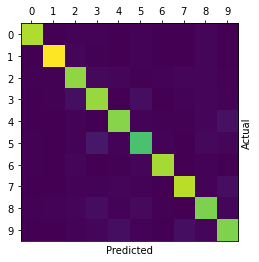

0.8802639849151477 0.0 0.008170961659333752 0.009270898805782527 0.002357008170961659 0.010999371464487744 0.0028284098051539913 0.0004714016341923319 0.013513513513513514 0.0028284098051539913
0.00031426775612822125 1.0 0.01524198617221873 0.006285355122564425 0.0028284098051539913 0.011627906976744186 0.0015713387806411063 0.0010999371464487744 0.018541797611565054 0.0018856065367693275
0.004714016341923318 0.0073852922690132 0.8340666247642992 0.02027027027027027 0.01571338780641106 0.0069138906348208675 0.010842237586423633 0.013199245757385292 0.015870521684475173 0.007228158390949088
0.0026712759270898804 0.004242614707730987 0.03614079195474544 0.8444374607165305 0.001257071024512885 0.036455059710873663 0.001257071024512885 0.008013827781269642 0.017284726587052168 0.011627906976744186
0.0009428032683846638 0.002042740414833438 0.010527969830295412 0.0018856065367693275 0.8186675047140164 0.010685103708359522 0.005813953488372093 0.006599622878692646 0.016499057196731615 0.0443

In [170]:
confusion_matrix = np.zeros((10, 10), dtype = float)
np.add.at(confusion_matrix, (train_labels, rbm.predict(train_data)), 1)
fig, ax = plt.subplots()
confusion_matrix /= np.amax(confusion_matrix)
ax.matshow(confusion_matrix, cmap = 'viridis')
plt.xticks(range(10))
plt.yticks(range(10))
plt.tick_params(bottom = False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.yaxis.set_label_position('right')
plt.show()
for r in confusion_matrix:
    print(*r)

9


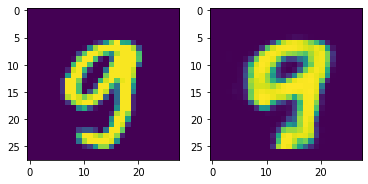

In [44]:
i = 4321
fig, axes = plt.subplots(1,2)
axes[0].imshow(test_data[i].reshape((28, 28)))
axes[1].imshow(rbm.generate(test_labels[i], test_data[i], iterations = 20).reshape((28, 28)))
print(test_labels[i])

In [93]:
from PIL import Image, ImageDraw, ImageFont
import os.path

In [175]:
cmap = plt.cm.get_cmap('viridis')
def image_activation(a):
    u, v = a.min(), a.max()
    pixels = (a - u) / (v - u)
    pixels = cmap(pixels)
    pixels = (pixels * 255).astype('uint8')[:, :, 0 : 3]
    return Image.fromarray(pixels)

def image_full(rbm0, rbm1, t, epoch, total_epochs):
    grid = (10, 10)
    activation_size = 28 * 4
    colsep, rowsep = 20, 20
    border = 2
    header_height = 100
    font = ImageFont.truetype('font.ttf', 40)
    hmargin, vmargin = 50, 25
    imgw = 2 * hmargin + grid[0] * (activation_size + 2 * border) + (grid[0] - 1) * colsep
    imgh = header_height + 2 * vmargin + grid[1] * (activation_size + 2 * border) + (grid[1] - 1) * rowsep
    img = Image.new('RGB', (imgw, imgh), 'white')
    draw = ImageDraw.Draw(img)
    draw.text((hmargin, vmargin), 'Epoch:', anchor = 'la', font = font, fill = 'black')
    draw.text((hmargin + 200, vmargin), str(epoch), anchor = 'ra', font = font, fill = 'black')
    rect_begin = hmargin + 3 * (2 * border + activation_size + colsep)
    rect_end = imgw - hmargin
    perc_epoch = epoch / total_epochs
    draw.rectangle([rect_begin, vmargin + 10, (1 - perc_epoch) * rect_begin + perc_epoch * rect_end, vmargin + 40], fill = '#1F77B4')
    draw.rectangle([rect_begin, vmargin + 10, rect_end, vmargin + 40], outline = 'black', width = border)
    W = (1 - t) * rbm0.W + t * rbm1.W
    for i in range(grid[0]):
        for j in range(grid[1]):
            x = hmargin + i * (activation_size + 2 * border) + i * colsep
            y = header_height + vmargin + j * (activation_size + 2 * border) + j * rowsep
            act = image_activation(W[grid[0] * j + i].reshape(28, 28))
            act = act.resize((activation_size, activation_size), 0)
            draw.rectangle([x, y, x + activation_size + 2 * border - 1, y + activation_size + 2 * border - 1], 'black')
            img.paste(act, (x + border, y + border))
    return img

def make_video(filenames, output, interval, frames):
    load_checkpoint = lambda i: pickle.load(open(filenames.format(i), 'rb'))
    b, e = interval
    loss = np.array(load_checkpoint(e).log['loss'])
    delta = np.zeros(loss.shape)
    delta[1 :] = np.abs(loss[1 :] - loss[: -1]) ** 0.7
    delta = delta.cumsum()
    delta *= (frames - 1) / delta[-1]
    print(*delta)
    i = 0
    rbm1 = load_checkpoint(0)
    for f in range(frames):
        j = np.searchsorted(delta, f) or 1
        if j > i:
            rbm0 = rbm1
            rbm1 = load_checkpoint(j)
            if j > i + 1:
                rbm0 = load_checkpoint(j - 1)
            i = j
        t = (f - delta[i - 1]) / (delta[i] - delta[i - 1])
        img = image_full(rbm0, rbm1, t, i, e + 1)
        img.save(os.path.join(output, f'frame{f:04}.png'))
        print(f, end = ' ')
    print()

In [177]:
make_video('100neurons/checkpoint-{:04}', 'video', [0, 198], 450)
#img = image_full(rbm,rbm,0, 50, 200)
#plt.imshow(img)
#img.save('img.png')
#plt.imshow(rbm.W[0].reshape(28, 28))

0.0 93.47558298246715 126.76586938875043 149.36370618213817 166.84808950778276 180.94449653212214 193.16320652690447 203.60906580861646 212.8102309318862 221.00301868223082 228.22531994982947 234.0225651743521 240.08337352903314 245.31021303348248 249.99294570355912 254.43647339880354 258.0231424684317 261.68796867922146 265.37839724874794 269.18235611286354 271.25791863751556 274.5417447414478 277.2794164704416 279.94465950942356 282.10257354766134 283.5591715077994 286.7295964027143 287.6503400011462 290.70109467472514 291.979785848767 293.68408257832556 295.45536525135 296.62071161363394 298.7789006379596 300.2208218314184 301.9671893474068 303.5666385277785 304.35694009248743 305.96513335547075 307.07987137006785 308.6375020798252 308.81186385588074 311.3041044909018 311.4951062353913 312.823965935371 313.88000376761295 313.981801018338 315.23179070290064 315.9831900714551 317.4133236098294 317.9572300182152 320.14694318102215 321.3230113187548 321.458218553391 321.64531646968885 3

In [49]:
cmap = plt.cm.get_cmap('gray')
def image_digit(a):
    pixels = cmap(a.reshape((28, 28)))
    pixels = (pixels * 255).astype('uint8')[:, :, 0 : 3]
    return Image.fromarray(pixels).resize((280, 280), 0)
i = 323
num = 1
img = image_digit(test_data[i])
img.save(f'slides/pictures/gibbs_sampling/input_{num}.png')
for j in range(10):
    img = image_digit(rbm.generate(test_labels[i], test_data[i], iterations = 20))
    img.save(f'slides/pictures/gibbs_sampling/output_{num}_{j}.png')

In [62]:
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.pipeline

class RBMSimple:
    
    def __init__(self, visible_num, hidden_num):
        self.visible_num = visible_num
        self.hidden_num = hidden_num
        normal = lambda s: np.random.default_rng().normal(0, 0.05, s)
        self.W = normal((hidden_num, visible_num))
        self.b = normal((visible_num, 1))
        self.c = normal((hidden_num, 1))
        self.linear_classifier = sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(),
            sklearn.linear_model.SGDClassifier())
        self.log = {
            'loss' : []
        }
    
    def train(self, epochs, data, labels, minibatch_size, optimizer):
        M = data.shape[0]
        it = 0
        for i in range(epochs):
            permutation = np.random.permutation(M)
            loss = 0;
            for b in range(0, M, minibatch_size):
                minibatch_data = data[permutation[b : b + minibatch_size]]
                minibatch_labels = labels[permutation[b : b + minibatch_size]]
                x0 = sample(minibatch_data).T

                h0P = sigmoid(self.c + self.W @ x0)
                wake = h0P @ x0.T

                h0 = sample(h0P)
                x1 = sample(sigmoid(self.b + self.W.T @ h0))
                h1P = sigmoid(self.c + self.W @ x1)
                dream = h1P @ x1.T
                
                self.W -= optimizer.get_update('W', (wake - dream) / minibatch_size)
                s = lambda v: np.sum(v, axis = 1, keepdims = True)
                self.b -= optimizer.get_update('b', (s(x0) - s(x1)) / minibatch_size)
                self.c -= optimizer.get_update('c', (s(h0P) - s(h1P)) / minibatch_size)
                
                loss += np.sum((x0 - x1) ** 2)
            self.log['loss'].append(loss / M)
            pickle.dump(self, open(f'checkpoints/checkpoint-{len(self.log["loss"]) - 1:04}', 'wb'))
            print('.', end = '')
        print('\nTraining linear classifier...')
        X = sample(sigmoid(self.c + self.W @ sample(data).T)).T
        Y = labels
        self.linear_classifier.fit(X, Y)
    
    def predict(self, data):
        if len(data.shape) == 1:
            data = data[None, :]
        X = sample(sigmoid(self.c + self.W @ sample(data).T)).T
        return self.linear_classifier.predict(X)

In [66]:
rbm = RBMSimple(28 * 28, 100)
rbm.train(200, train_data, train_labels, 60, SGDMomentum(0.05, 0.9))

........................................................................................................................................................................................................
Training linear classifier...


In [81]:
a=np.array([1,2,3])

In [82]:
a[:,1:2]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed